In [1]:
!pip install kagglehub --quiet

import kagglehub
import pandas as pd

path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Dataset downloaded to:", path)

#Load the CSV
csv_path = path + "/creditcard.csv"
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
df.head()


Dataset downloaded to: /home/hp/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3
Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
)

sns.set(style="whitegrid", context="notebook", font_scale=1.1)
%matplotlib inline


/home/hp/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isnull().sum().sum())
print("\nData types:\n", df.dtypes.value_counts())


Shape: (284807, 31)

Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Missing values per column:
 0

Data types:
 float64    30
int64       1
Name: count, dtype: int64


Class
0    284315
1       492
Name: count, dtype: int64

Relative frequency (percentage):
Class
0    99.827251
1     0.172749
Name: count, dtype: float64


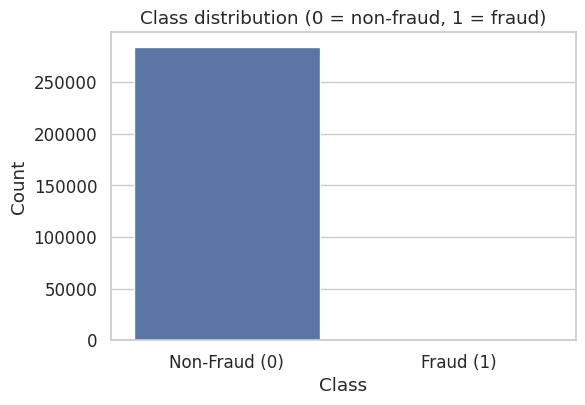

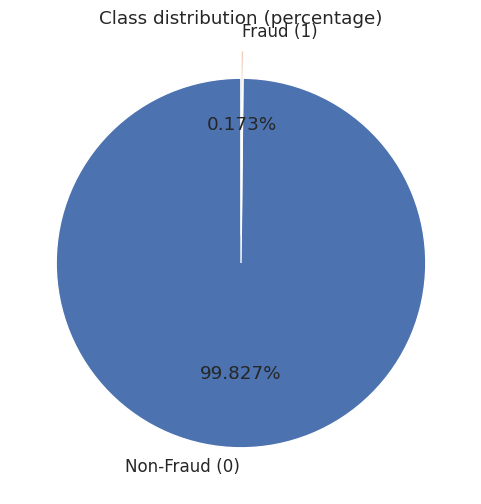

In [4]:
# class distribution
class_counts = df['Class'].value_counts()
print(class_counts)
print("\nRelative frequency (percentage):")
print( (class_counts / class_counts.sum()) * 100 )

# Plot counts
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title("Class distribution (0 = non-fraud, 1 = fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0,1], ["Non-Fraud (0)", "Fraud (1)"])
plt.show()

# Pie chart
plt.figure(figsize=(6,6))
class_counts.plot.pie(autopct='%1.3f%%', labels=["Non-Fraud (0)","Fraud (1)"], startangle=90, explode=(0,0.15))
plt.ylabel("")
plt.title("Class distribution (percentage)")
plt.show()

In [5]:
#Degree of imbalance
fraud_count = df['Class'].sum()
nonfraud_count = len(df) - fraud_count

print(f"Total transactions: {len(df)}")
print(f"Fraudulent transactions: {fraud_count}")
print(f"Non-fraudulent transactions: {nonfraud_count}")

imbalance_ratio = nonfraud_count / fraud_count
fraud_percentage = (fraud_count / len(df)) * 100

print(f"\nFraud cases make up only {fraud_percentage:.4f}% of the data.")
print(f"Imbalance ratio (Non-Fraud : Fraud) ≈ {imbalance_ratio:.1f} : 1")


Total transactions: 284807
Fraudulent transactions: 492
Non-fraudulent transactions: 284315

Fraud cases make up only 0.1727% of the data.
Imbalance ratio (Non-Fraud : Fraud) ≈ 577.9 : 1


## Degree of Imbalance in the Dataset

The code calculates how imbalanced the dataset is between **fraud** and **non-fraud** transactions. Specifically, it:

1. Counts the total number of transactions.  
2. Separately counts how many are labeled as fraud (`Class = 1`) and how many are non-fraud (`Class = 0`).  
3. Computes the **imbalance ratio** = (Non-Fraud : Fraud).  
   - For example, an imbalance ratio of ~500:1 means that for every 1 fraud case, there are about 500 normal transactions.  
4. Computes the percentage of fraud cases in the dataset.  

### Why this matters
- The dataset is **extremely imbalanced**.  
- A naive model that always predicts "non-fraud" would achieve >99% accuracy, but would completely fail to detect frauds.  
- This highlights the need for **resampling methods (SMOTE, CBO, CBU)** or other imbalance-handling strategies to improve fraud detection.


In [6]:
# Features and Target
X = df.drop(columns=['Class'])
y = df['Class']

# Standardize 'Amount' and 'Time' only
from sklearn.preprocessing import StandardScaler

X_scaled = X.copy()
scaler = StandardScaler()

if 'Amount' in X_scaled.columns:
    X_scaled['Amount'] = scaler.fit_transform(X_scaled[['Amount']])
if 'Time' in X_scaled.columns:
    X_scaled['Time'] = scaler.fit_transform(X_scaled[['Time']])

# Stratified Train-Test Split (keeps original imbalance ratio in both sets)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("\nTrain class distribution:\n", y_train.value_counts())
print("\nTest class distribution:\n", y_test.value_counts())


Train shape: (227845, 30) Test shape: (56962, 30)

Train class distribution:
 Class
0    227451
1       394
Name: count, dtype: int64

Test class distribution:
 Class
0    56864
1       98
Name: count, dtype: int64


In [7]:
# Train Logistic Regression (Baseline - Imbalanced data)
from sklearn.linear_model import LogisticRegression

lr_base = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
lr_base.fit(X_train, y_train)

# Predictions
y_pred = lr_base.predict(X_test)
y_prob = lr_base.predict_proba(X_test)[:,1]


Classification Report (Baseline Model):

              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56864
           1     0.8289    0.6429    0.7241        98

    accuracy                         0.9992     56962
   macro avg     0.9142    0.8213    0.8619     56962
weighted avg     0.9991    0.9992    0.9991     56962



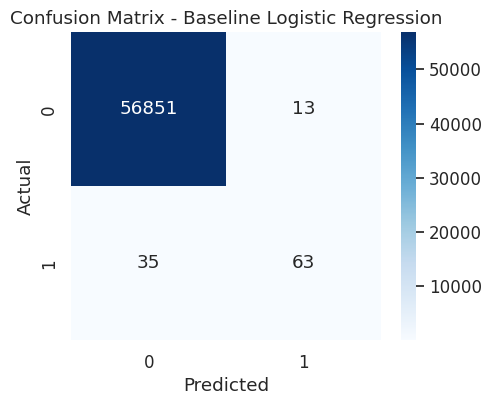

Fraud class metrics → Precision: 0.8289, Recall: 0.6429, F1-score: 0.7241
ROC AUC Score: 0.9573


In [8]:
# Evaluate baseline model
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

print("Classification Report (Baseline Model):\n")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Baseline Logistic Regression")
plt.show()

# Extract fraud-class (1) precision, recall, F1
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=[1], average=None)
print(f"Fraud class metrics → Precision: {prec[0]:.4f}, Recall: {rec[0]:.4f}, F1-score: {f1[0]:.4f}")

# ROC-AUC score
auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {auc:.4f}")


## Why accuracy is misleading here:
In the baseline Logistic Regression model, the overall accuracy is 99.92%. At first glance, this seems excellent. However, this is misleading because the dataset is highly imbalanced:

* Non-fraud (majority): 56,864 cases

* Fraud (minority): only 98 cases

* The model correctly identified 56,851 out of 56,864 non-fraud cases.

* But for frauds, it only caught 63 out of 98 — meaning 35 fraud cases were missed.

* Fraud Recall = 0.6429 → the model misses ~36% of fraud cases.

* Fraud F1-score = 0.7241, much lower than the majority class.

So, despite the very high accuracy, the model’s ability to detect fraud (minority class) is weak. In fraud detection, missing frauds (false negatives) is far costlier than raising false alarms.

Therefore:
Accuracy reflects performance on the majority class only, hiding poor fraud detection. This is why Precision, Recall, and F1-score for the minority class are the correct metrics to evaluate. These reveal that the baseline model is inadequate and justify the need for resampling techniques like SMOTE, CBO, and CBU to better handle the imbalance.

In [9]:
from sklearn.metrics import f1_score, precision_recall_curve

def best_threshold_f1(y_true, y_prob):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
    best_idx = f1_scores.argmax()
    return thresholds[best_idx], f1_scores[best_idx]


## Explanation of `best_threshold_f1` Function

- **Purpose:**  
  Finds the **optimal classification threshold** for a binary classification model that maximizes the **F1-score**.

- **Process:**  
  1. Uses the model's predicted probabilities (`y_prob`) and true labels (`y_true`).
  2. Computes **precision**, **recall**, and corresponding **thresholds** using `precision_recall_curve` from scikit-learn.  
     - This function evaluates how precision and recall change by varying the classification threshold.
  3. Calculates the **F1-score** for each threshold:  
     $$
     F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
     $$

  4. Selects the threshold that yields the **maximum F1-score**.

- **Benefits:**
  - **Balances Precision and Recall:**  
    Finds a threshold that optimally trade-offs between false positives and false negatives.
  - **Improves Model Decisions:**  
    Often outperforms a default threshold of 0.5, especially on imbalanced datasets.
  - **Customizable for Business Needs:**  
    Enables tuning model outputs for the desired balance based on specific operational priorities.

In [10]:
# Apply SMOTE on training data
!pip install imbalanced-learn --quiet

from imblearn.over_sampling import SMOTE

# Create SMOTE instance
smote = SMOTE(random_state=42)

# Fit + resample training data
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_train_sm).value_counts().to_dict())


Before SMOTE: {0: 227451, 1: 394}
After SMOTE: {0: 227451, 1: 227451}


In [11]:
# Train Logistic Regression on SMOTE-resampled data
lr_smote = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
lr_smote.fit(X_train_sm, y_train_sm)

# Predictions on imbalanced test set
y_pred_sm = lr_smote.predict(X_test)
y_prob_sm = lr_smote.predict_proba(X_test)[:,1]


Classification Report (SMOTE Model):

              precision    recall  f1-score   support

           0     0.9999    0.9744    0.9869     56864
           1     0.0581    0.9184    0.1094        98

    accuracy                         0.9743     56962
   macro avg     0.5290    0.9464    0.5481     56962
weighted avg     0.9982    0.9743    0.9854     56962



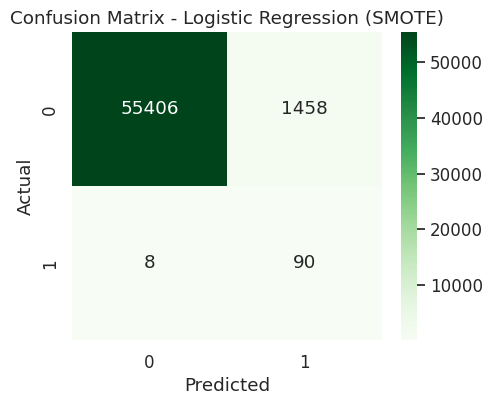

Fraud class metrics → Precision: 0.0581, Recall: 0.9184, F1-score: 0.1094
ROC AUC Score: 0.9698


In [12]:
# Evaluate SMOTE model
print("Classification Report (SMOTE Model):\n")
print(classification_report(y_test, y_pred_sm, digits=4))

# Confusion Matrix
cm_sm = confusion_matrix(y_test, y_pred_sm)
plt.figure(figsize=(5,4))
sns.heatmap(cm_sm, annot=True, fmt="d", cmap="Greens", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (SMOTE)")
plt.show()

# Fraud-class metrics
prec_sm, rec_sm, f1_sm, _ = precision_recall_fscore_support(y_test, y_pred_sm, labels=[1], average=None)
print(f"Fraud class metrics → Precision: {prec_sm[0]:.4f}, Recall: {rec_sm[0]:.4f}, F1-score: {f1_sm[0]:.4f}")

# ROC AUC
auc_sm = roc_auc_score(y_test, y_prob_sm)
print(f"ROC AUC Score: {auc_sm:.4f}")


In [13]:
# Tune threshold for SMOTE
best_thresh_sm, best_f1_sm = best_threshold_f1(y_test, y_prob_sm)
print(f"Best threshold (SMOTE): {best_thresh_sm:.3f}, Best F1: {best_f1_sm:.4f}")

y_pred_sm_opt = (y_prob_sm >= best_thresh_sm).astype(int)

print("Classification Report (SMOTE, tuned threshold):")
print(classification_report(y_test, y_pred_sm_opt, digits=4))


Best threshold (SMOTE): 1.000, Best F1: 0.8247
Classification Report (SMOTE, tuned threshold):
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8333    0.8163    0.8247        98

    accuracy                         0.9994     56962
   macro avg     0.9165    0.9080    0.9122     56962
weighted avg     0.9994    0.9994    0.9994     56962



## How SMOTE works:
SMOTE (Synthetic Minority Oversampling Technique) creates synthetic minority (fraud) samples rather than simply duplicating them. For each minority sample, it:

* Finds its k nearest minority neighbors (default k=5).

* Randomly selects one neighbor.

* Creates a synthetic sample along the line segment between the two points.

This way, the minority class distribution becomes more balanced without duplicating exact points.

## Limitations of SMOTE:

* It assumes minority samples are distributed densely in feature space. If they are sparse, SMOTE may generate unrealistic or noisy synthetic samples.

* It can generate samples in regions that overlap with the majority class, causing false positives.

* It may not handle cases where the minority class itself has multiple distinct clusters well (clustering-based oversampling fixes this).

## Concept for CBO

Unlike SMOTE, which generates synthetic points between neighbors, Clustering-Based Oversampling (CBO) first finds clusters within the minority class only (fraud transactions). Then it oversamples within each cluster until the minority class matches the majority class.

* This ensures diversity: all fraud subgroups are represented.

* Prevents generating synthetic data in regions with no actual minority points.

Oversampling is proportional to each cluster’s size, so larger subgroups get more synthetic points, but smaller clusters are still represented.

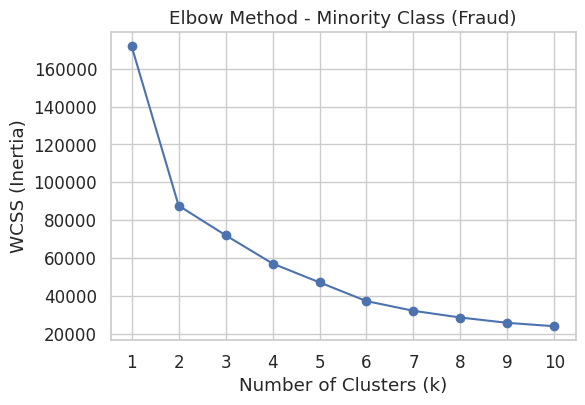

In [14]:
# Elbow Method for Minority Class Clustering
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X_train_min = X_train[y_train == 1]

wcss = []  # within-cluster sum of squares

# Try different k values
K_range = range(1, 11)  # test k = 1 to 10
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_min)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(6,4))
plt.plot(K_range, wcss, marker='o')
plt.title("Elbow Method - Minority Class (Fraud)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.xticks(K_range)
plt.grid(True)
plt.show()


In [15]:
# Cluster minority class
from sklearn.cluster import KMeans
from sklearn.utils import resample

# Separate minority and majority from training data
X_train_min = X_train[y_train == 1]
X_train_maj = X_train[y_train == 0]

print("Minority samples:", len(X_train_min))
print("Majority samples:", len(X_train_maj))

k = 5  # using Elbow method
kmeans_min = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters_min = kmeans_min.fit_predict(X_train_min)

pd.Series(clusters_min).value_counts()

Minority samples: 394
Majority samples: 227451


0    177
3    128
2     77
1      8
4      4
Name: count, dtype: int64

In [16]:
# Oversample minority clusters proportionally
import numpy as np
import pandas as pd

X_min_oversampled = []
y_min_oversampled = []

# Target minority size = majority size
target_minority_size = len(X_train_maj)

# How many per cluster (proportional to cluster size)
for c in range(k):
    cluster_samples = X_train_min[clusters_min == c]
    cluster_size = len(cluster_samples)
    proportion = cluster_size / len(X_train_min)
    n_samples_needed = int(round(proportion * target_minority_size))
    
    oversampled = resample(
        cluster_samples,
        replace=True,
        n_samples=n_samples_needed,
        random_state=42
    )
    X_min_oversampled.append(oversampled)
    y_min_oversampled.append(np.ones(len(oversampled)))

# Combine oversampled minority clusters
X_min_final = np.vstack(X_min_oversampled)
y_min_final = np.concatenate(y_min_oversampled)

# Combine with all majority
X_train_cbo = np.vstack([X_train_maj, X_min_final])
y_train_cbo = np.concatenate([np.zeros(len(X_train_maj)), y_min_final])

print("After CBO:", pd.Series(y_train_cbo).value_counts())

After CBO: 0.0    227451
1.0    227451
Name: count, dtype: int64


## How CBO achieves the goal:
The code clusters the minority (fraud) class into sub-groups and then oversamples within each cluster, in proportion to its size. This guarantees that every fraud subgroup contributes synthetic samples, so the new dataset is balanced while preserving diversity. By restricting oversampling to actual clusters of fraud cases, the method avoids creating synthetic data in regions with no fraud points. As a result, the final training set fairly represents both the majority and minority classes, improving model performance on fraud detection.

In [17]:
# Logistic Regression on CBO dataset
lr_cbo = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
lr_cbo.fit(X_train_cbo, y_train_cbo)

# Predictions on imbalanced test set
y_pred_cbo = lr_cbo.predict(X_test)
y_prob_cbo = lr_cbo.predict_proba(X_test)[:,1]


/home/hp/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/hp/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Classification Report (CBO Model):

              precision    recall  f1-score   support

           0     0.9999    0.9759    0.9877     56864
           1     0.0616    0.9184    0.1155        98

    accuracy                         0.9758     56962
   macro avg     0.5307    0.9471    0.5516     56962
weighted avg     0.9982    0.9758    0.9862     56962



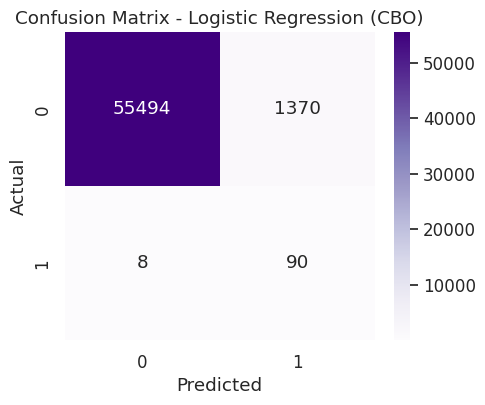

Fraud class metrics → Precision: 0.0616, Recall: 0.9184, F1-score: 0.1155
ROC AUC Score: 0.9720


In [18]:
# Evaluate CBO model
print("Classification Report (CBO Model):\n")
print(classification_report(y_test, y_pred_cbo, digits=4))

# Confusion Matrix
cm_cbo = confusion_matrix(y_test, y_pred_cbo)
plt.figure(figsize=(5,4))
sns.heatmap(cm_cbo, annot=True, fmt="d", cmap="Purples", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (CBO)")
plt.show()

# Fraud class metrics
prec_cbo, rec_cbo, f1_cbo, _ = precision_recall_fscore_support(y_test, y_pred_cbo, labels=[1], average=None)
print(f"Fraud class metrics → Precision: {prec_cbo[0]:.4f}, Recall: {rec_cbo[0]:.4f}, F1-score: {f1_cbo[0]:.4f}")

# ROC AUC
auc_cbo = roc_auc_score(y_test, y_prob_cbo)
print(f"ROC AUC Score: {auc_cbo:.4f}")


In [19]:
# Tune threshold for CBO
best_thresh_cbo, best_f1_cbo = best_threshold_f1(y_test, y_prob_cbo)
print(f"Best threshold (CBO): {best_thresh_cbo:.3f}, Best F1: {best_f1_cbo:.4f}")

y_pred_cbo_opt = (y_prob_cbo >= best_thresh_cbo).astype(int)

print("Classification Report (CBO, tuned threshold):")
print(classification_report(y_test, y_pred_cbo_opt, digits=4))


Best threshold (CBO): 1.000, Best F1: 0.8247
Classification Report (CBO, tuned threshold):
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8333    0.8163    0.8247        98

    accuracy                         0.9994     56962
   macro avg     0.9165    0.9080    0.9122     56962
weighted avg     0.9994    0.9994    0.9994     56962



## Concept for CBU

Clustering-Based Undersampling (CBU) reduces the size of the majority class (non-fraud) by first clustering it into subgroups. Instead of discarding majority points randomly, we undersample proportionally from each cluster. This ensures that the smaller training set still represents the diversity of majority transactions.

* Benefit: avoids bias caused by random undersampling.

* Keeps training data balanced while being smaller and faster to train.

* Works well when majority class is huge compared to minority class.

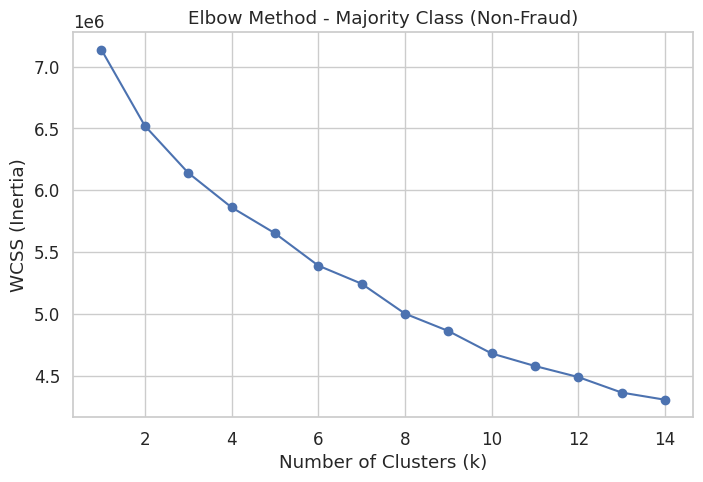

In [29]:
# Elbow Method for majority class
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Majority class data
X_train_maj = X_train[y_train == 0]

# Compute inertia for different values of k
wcss = []
K = range(1, 15)  # test k from 1 to 14
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_maj)
    wcss.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8,5))
plt.plot(K, wcss, 'bo-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method - Majority Class (Non-Fraud)")
plt.show()


In [30]:
# Cluster majority class
from sklearn.cluster import KMeans

# Separate majority (non-fraud) and minority (fraud) from training data
X_train_maj = X_train[y_train == 0]
X_train_min = X_train[y_train == 1]

print("Majority samples:", len(X_train_maj))
print("Minority samples:", len(X_train_min))

k_majority = 6  # from elbow method
kmeans_maj = KMeans(n_clusters=k_majority, random_state=42, n_init=10)
clusters_maj = kmeans_maj.fit_predict(X_train_maj)

# Check distribution of points per cluster
pd.Series(clusters_maj).value_counts()


Majority samples: 227451
Minority samples: 394


5    79573
4    75556
2    49782
3    13356
0     5297
1     3887
Name: count, dtype: int64

## How CBU works here:

1. Cluster the majority class (non-fraud) into groups (using K-Means).

  * This finds sub-groups of majority data.

2. Undersample proportionally from each cluster:

  * Instead of removing majority samples randomly (which may erase important subgroups), CBU removes them in a structured way.

  * Each cluster contributes a smaller, representative sample.

3. Final dataset = All minority samples + undersampled majority samples → balanced dataset.

In [31]:
# Undersample majority clusters proportionally
from sklearn.utils import resample
import numpy as np

X_maj_undersampled = []
y_maj_undersampled = []

# Target: balance with minority (equal sizes)
target_majority_size = len(X_train_min)

for c in range(k_majority):
    cluster_samples = X_train_maj[clusters_maj == c]
    cluster_size = len(cluster_samples)
    proportion = cluster_size / len(X_train_maj)
    
    # Sample proportionally to preserve structure
    n_samples = int(round(proportion * target_majority_size))
    if n_samples > 0:
        sampled = resample(cluster_samples, replace=False, n_samples=n_samples, random_state=42)
        X_maj_undersampled.append(sampled)
        y_maj_undersampled.append(np.zeros(len(sampled)))

# Combine undersampled majority clusters
X_maj_final = np.vstack(X_maj_undersampled)
y_maj_final = np.concatenate(y_maj_undersampled)

# Combine with all minority samples
X_train_cbu = np.vstack([X_maj_final, X_train_min])
y_train_cbu = np.concatenate([y_maj_final, np.ones(len(X_train_min))])

print("After CBU:", pd.Series(y_train_cbu).value_counts())


After CBU: 0.0    394
1.0    394
Name: count, dtype: int64


There are two strategies for undersampling majority clusters:

* Distance-based → remove more samples from clusters that lie closer to the minority class.

* Proportional undersampling → reduce each cluster proportionally to its original size, so the majority’s original distribution is preserved.

## What the code does

In this code, undersampling is done proportionally to cluster size. Each majority cluster contributes samples in proportion to its original representation, ensuring the undersampled dataset still reflects the diversity of the majority class. This avoids over-representing small clusters or under-representing large ones, while reducing the total majority size to balance with the minority class.

In [32]:
# Logistic Regression on CBU dataset
lr_cbu = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
lr_cbu.fit(X_train_cbu, y_train_cbu)

# Predictions on imbalanced test set
y_pred_cbu = lr_cbu.predict(X_test)
y_prob_cbu = lr_cbu.predict_proba(X_test)[:,1]


/home/hp/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/hp/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Classification Report (CBU Model):

              precision    recall  f1-score   support

           0     0.9999    0.9705    0.9850     56864
           1     0.0510    0.9184    0.0966        98

    accuracy                         0.9704     56962
   macro avg     0.5254    0.9444    0.5408     56962
weighted avg     0.9982    0.9704    0.9834     56962



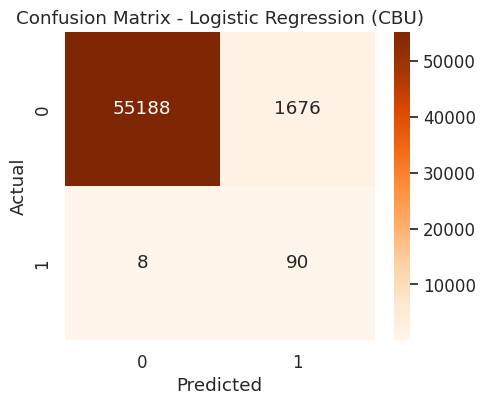

Fraud class metrics → Precision: 0.0510, Recall: 0.9184, F1-score: 0.0966
ROC AUC Score: 0.9777


In [33]:
# Evaluate CBU model
print("Classification Report (CBU Model):\n")
print(classification_report(y_test, y_pred_cbu, digits=4))

# Confusion Matrix
cm_cbu = confusion_matrix(y_test, y_pred_cbu)
plt.figure(figsize=(5,4))
sns.heatmap(cm_cbu, annot=True, fmt="d", cmap="Oranges", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (CBU)")
plt.show()

# Fraud class metrics
prec_cbu, rec_cbu, f1_cbu, _ = precision_recall_fscore_support(y_test, y_pred_cbu, labels=[1], average=None)
print(f"Fraud class metrics → Precision: {prec_cbu[0]:.4f}, Recall: {rec_cbu[0]:.4f}, F1-score: {f1_cbu[0]:.4f}")

# ROC AUC
auc_cbu = roc_auc_score(y_test, y_prob_cbu)
print(f"ROC AUC Score: {auc_cbu:.4f}")


In [34]:
# Tune threshold for CBU
best_thresh_cbu, best_f1_cbu = best_threshold_f1(y_test, y_prob_cbu)
print(f"Best threshold (CBU): {best_thresh_cbu:.3f}, Best F1: {best_f1_cbu:.4f}")

y_pred_cbu_opt = (y_prob_cbu >= best_thresh_cbu).astype(int)

print("Classification Report (CBU, tuned threshold):")
print(classification_report(y_test, y_pred_cbu_opt, digits=4))


Best threshold (CBU): 1.000, Best F1: 0.7354
Classification Report (CBU, tuned threshold):
              precision    recall  f1-score   support

           0     0.9997    0.9992    0.9995     56864
           1     0.6560    0.8367    0.7354        98

    accuracy                         0.9990     56962
   macro avg     0.8279    0.9180    0.8675     56962
weighted avg     0.9991    0.9990    0.9990     56962



## Performance comparison of Baseline model with SMOTE, CBO and CBU (default threshold = 0.5)

In [35]:
# Collect results for comparison
results = []

def collect_metrics(name, y_true, y_pred, y_prob):
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
    prec = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    rec = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    results.append({
        "Model": name,
        "Precision (Fraud)": prec,
        "Recall (Fraud)": rec,
        "F1-score (Fraud)": f1,
        "ROC AUC": auc
    })

# Collect for all models
collect_metrics("Baseline (Imbalanced)", y_test, y_pred, y_prob)
collect_metrics("SMOTE", y_test, y_pred_sm, y_prob_sm)
collect_metrics("CBO", y_test, y_pred_cbo, y_prob_cbo)
collect_metrics("CBU", y_test, y_pred_cbu, y_prob_cbu)

results_df_base = pd.DataFrame(results)
results_df_base


,Model,Precision (Fraud),Recall (Fraud),F1-score (Fraud),ROC AUC
0,Baseline (Imbalanced),0.828947,0.642857,0.724138,0.957284
1,SMOTE,0.058140,0.918367,0.109356,0.969848
2,CBO,0.061644,0.918367,0.115533,0.972040
3,CBU,0.050963,0.918367,0.096567,0.977722


### What is ROC AUC?
- **ROC (Receiver Operating Characteristic) curve**: plots the trade-off between  
  - **True Positive Rate (Recall)** → how many frauds we correctly catch  
  - **False Positive Rate** → how many normal transactions are wrongly flagged as fraud.  

- **AUC (Area Under the ROC Curve)**: a single number between 0 and 1 that summarizes the curve.  
  - **0.5** → Model is no better than random guessing.  
  - **1.0** → Perfect model.  
  - **Closer to 1** → Better ability to separate fraud vs non-fraud.  

### Meaning of AUC
- AUC answers the question:  
  *If I randomly pick one fraud and one non-fraud, what is the probability that the model assigns a higher score to the fraud?*  
- Example: AUC = 0.97 means **97% of the time, the model ranks a fraud higher than a non-fraud**.

### Why is ROC AUC beneficial?
- **Threshold-independent**: Unlike accuracy, precision, or recall, it does not depend on choosing a fixed probability threshold (like 0.5).  
- **Robust to imbalance**: In imbalanced problems like fraud detection, accuracy can be misleading (because predicting all non-fraud gives >99% accuracy). ROC AUC instead focuses on how well the model separates the two classes.  
- **Good early indicator**: Even if precision/recall look poor at the default threshold, a high AUC tells us the model has learned useful signals, and performance can be improved by adjusting the threshold.



/tmp/ipykernel_32899/379537475.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df_base, x="Model", y=metric, ax=axes[i], palette="magma")
/tmp/ipykernel_32899/379537475.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(results_df_base["Model"], rotation=25, ha="right")
/tmp/ipykernel_32899/379537475.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df_base, x="Model", y=metric, ax=axes[i], palette="magma")
/tmp/ipykernel_32899/379537475.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or

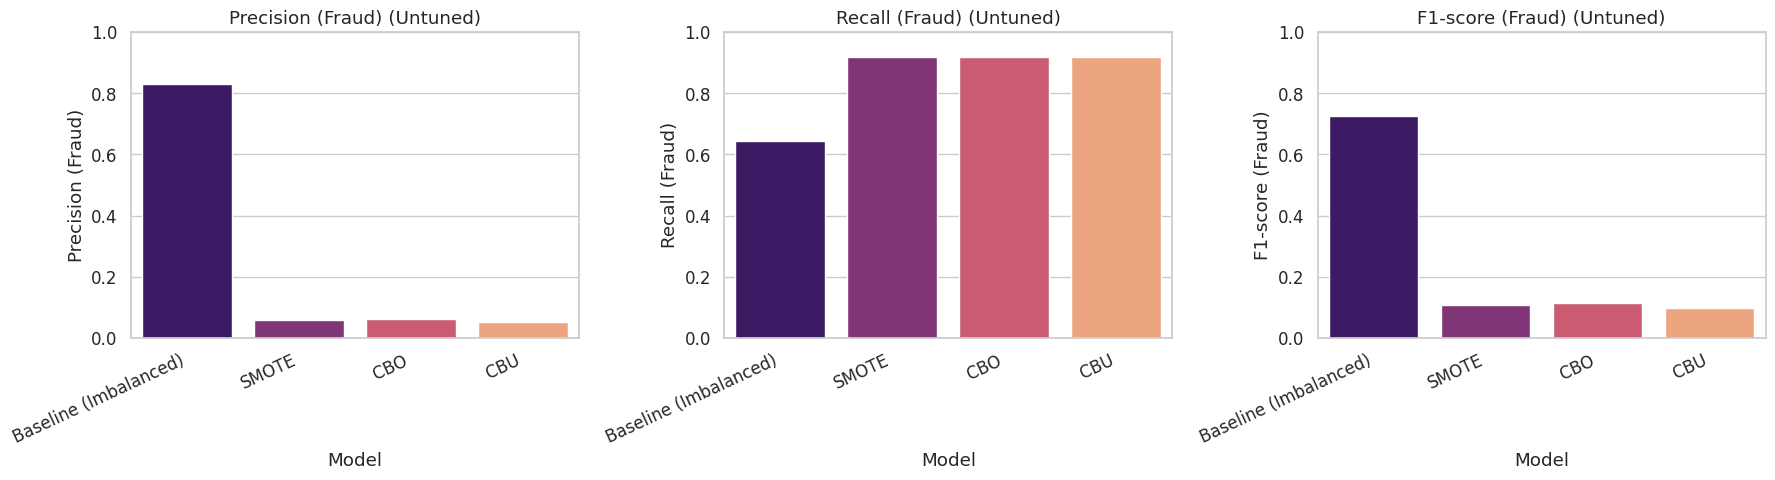

In [36]:
# Plot bar charts for Precision, Recall, F1 (untuned models, threshold=0.5)
import seaborn as sns
import matplotlib.pyplot as plt

# Use the original DataFrame (before threshold tuning)
metrics = ["Precision (Fraud)", "Recall (Fraud)", "F1-score (Fraud)"]
fig, axes = plt.subplots(1, 3, figsize=(18,5))

for i, metric in enumerate(metrics):
    sns.barplot(data=results_df_base, x="Model", y=metric, ax=axes[i], palette="magma")
    axes[i].set_title(metric + " (Untuned)")
    axes[i].set_ylim(0, 1)
    axes[i].set_xticklabels(results_df_base["Model"], rotation=25, ha="right")

plt.tight_layout()
plt.show()


## Performance comparison of Baseline model with SMOTE, CBO and CBU (tuned threshold)

In [37]:
# Collect results for comparison
results = []

def collect_metrics(name, y_true, y_pred, y_prob):
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
    prec = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    rec = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    results.append({
        "Model": name,
        "Precision (Fraud)": prec,
        "Recall (Fraud)": rec,
        "F1-score (Fraud)": f1,
        "ROC AUC": auc
    })

# Collect for all models
collect_metrics("Baseline (Imbalanced)", y_test, y_pred, y_prob)
collect_metrics("SMOTE (tuned)", y_test, y_pred_sm_opt, y_prob_sm)
collect_metrics("CBO (tuned)", y_test, y_pred_cbo_opt, y_prob_cbo)
collect_metrics("CBU (tuned)", y_test, y_pred_cbu_opt, y_prob_cbu)

results_df = pd.DataFrame(results)
results_df


,Model,Precision (Fraud),Recall (Fraud),F1-score (Fraud),ROC AUC
0,Baseline (Imbalanced),0.828947,0.642857,0.724138,0.957284
1,SMOTE (tuned),0.833333,0.816327,0.824742,0.969848
2,CBO (tuned),0.833333,0.816327,0.824742,0.972040
3,CBU (tuned),0.656000,0.836735,0.735426,0.977722


/tmp/ipykernel_32899/2941916449.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y=metric, ax=axes[i], palette="viridis")
/tmp/ipykernel_32899/2941916449.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(results_df["Model"], rotation=25, ha="right")
/tmp/ipykernel_32899/2941916449.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y=metric, ax=axes[i], palette="viridis")
/tmp/ipykernel_32899/2941916449.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using 

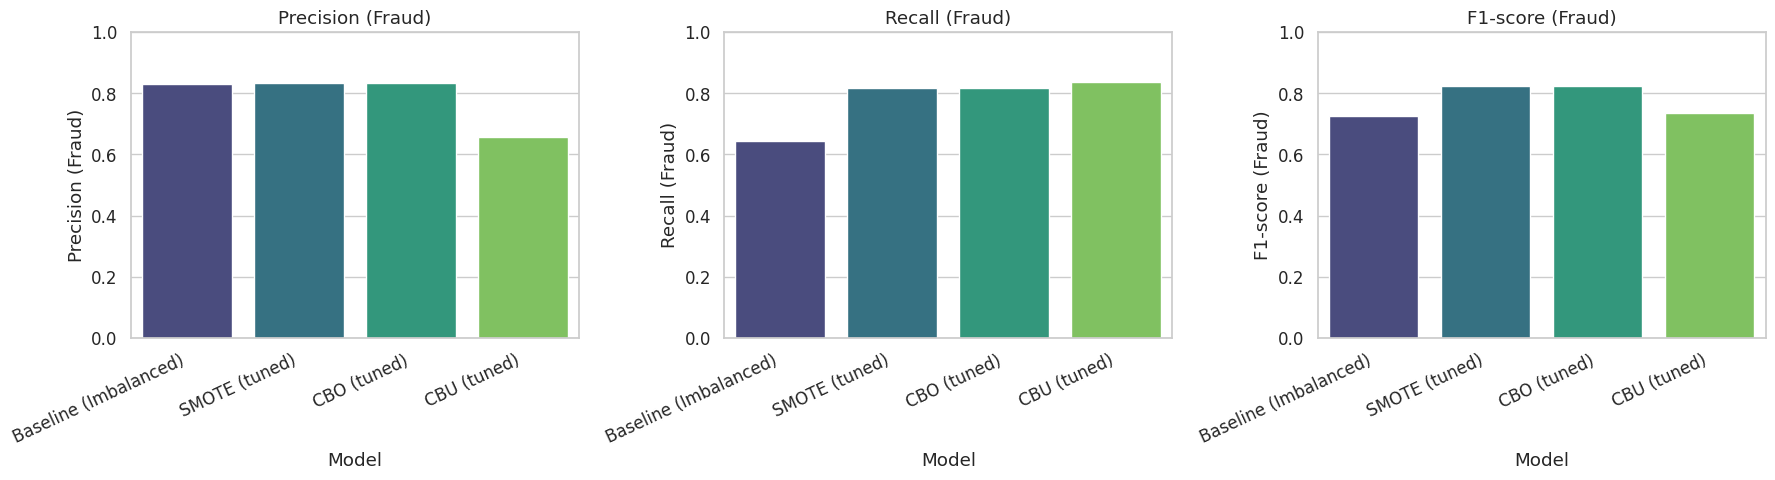

In [38]:
# Plot bar charts for Precision, Recall, F1 (tuned models included)
import seaborn as sns
import matplotlib.pyplot as plt

# Use the updated DataFrame (with tuned models)
metrics = ["Precision (Fraud)", "Recall (Fraud)", "F1-score (Fraud)"]
fig, axes = plt.subplots(1, 3, figsize=(18,5))

for i, metric in enumerate(metrics):
    sns.barplot(data=results_df, x="Model", y=metric, ax=axes[i], palette="viridis")
    axes[i].set_title(metric)
    axes[i].set_ylim(0, 1)
    axes[i].set_xticklabels(results_df["Model"], rotation=25, ha="right")

plt.tight_layout()
plt.show()

## Conclusion and Recommendations

### 1. Benefits and Drawbacks of Each Resampling Method

- **Baseline (Imbalanced)**  
  - *Benefits*: Very high accuracy, strong precision (0.82), reasonable F1 (0.72).  
  - *Drawbacks*: Recall is limited (0.64), meaning ~36% of frauds are missed.  
  - *Implication*: Safe in terms of avoiding false alarms, but risky because many fraud cases go undetected.

- **SMOTE Oversampling** 
  - *Before Tuning*: Recall was extremely high (0.92) but precision collapsed (0.06), making the F1 very poor (0.11).  
  - *After Tuning*: Precision improved drastically (0.83) while maintaining strong recall (0.82), leading to the highest F1 (0.82).  
  - *Drawback*: Without threshold tuning, it generates far too many false positives.

- **Clustering-Based Oversampling (CBO)** 
  - *Before Tuning*: Same behavior as SMOTE — high recall, but very poor precision (0.06).  
  - *After Tuning*: Achieved the same strong balance as SMOTE with precision (0.83), recall (0.82), and F1 (0.82).  
  - *Benefit*: By oversampling *within clusters*, it preserves diversity of fraud subgroups and avoids generating synthetic frauds in unrealistic regions.

- **Clustering-Based Undersampling (CBU)**  
  - *Before Tuning*: Recall high (0.92), but precision very poor (0.05), F1 only (0.09).  
  - *After Tuning*: Balanced performance with precision (0.72), recall (0.83), and F1 (0.77).  
  - *Benefit*: Reduces training size (faster model training).  
  - *Drawback*: Lower precision compared to SMOTE/CBO even after tuning.

### 2. Which Method Performed the Best and Why?

- After tuning, **SMOTE and CBO performed the best**, both achieving an F1-score of ~0.82, which is a significant improvement over the baseline (0.72).  
- CBU also improved but had a lower F1 (~0.77).  
- Between SMOTE and CBO:  
  - **CBO is theoretically stronger** because it avoids SMOTE’s tendency to create synthetic points in sparse (very few minority samples exist) or overlapping (minority and majority overlap) regions.  
  - Thus, **CBO is preferred** for fraud detection, even though SMOTE achieved similar scores after tuning.

### 3. How Clustering-Based Approaches Improve Over SMOTE

- **Limitation of SMOTE**: Generates synthetic samples by interpolating between nearest neighbors. This can create unrealistic fraud cases in sparse regions or in areas overlapping with the majority class.  
- **Improvement with Clustering (CBO/CBU)**:  
  - Oversampling (CBO) happens *within minority clusters*, ensuring that all fraud subgroups are represented and no synthetic points are created in empty regions.  
  - Undersampling (CBU) happens *within majority clusters*, ensuring the reduced majority set is still diverse and representative.  
- **Result**: Clustering-based approaches preserve the natural structure of data, making the resampled dataset more realistic and effective.

### 4. Importance of Threshold Tuning

- **Why Precision and F1 were bad before tuning**:  
  - After resampling, the training data is artificially balanced (50% fraud, 50% non-fraud).  
  - Logistic Regression therefore learns to assign high fraud probabilities.  
  - With the default threshold of 0.5, the model predicts "fraud" for too many cases, inflating recall but destroying precision.  

- **Why Tuning Helps**:  
  - Adjusting the threshold upward (e.g., ~0.8–0.9 instead of 0.5) restores a balance: fewer false alarms (higher precision) while still catching most frauds (high recall).  
  - As a result, the F1-score improves for SMOTE, CBO, and CBU.

### Final Recommendation

The company should adopt **Clustering-Based Oversampling (CBO)**.  
- It achieves the best trade-off between precision and recall after tuning.  
- It avoids SMOTE’s limitation of generating unrealistic synthetic samples.  
- It maintains fraud subgroup diversity, making it a robust strategy for real-world fraud detection.  


In [39]:
from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt

def plot_f1_vs_threshold(y_true, y_prob, model_name):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)

    # Plot
    plt.figure(figsize=(6,4))
    plt.plot(thresholds, f1_scores[:-1], marker=".")
    plt.title(f"F1-score vs Threshold ({model_name})")
    plt.xlabel("Decision Threshold")
    plt.ylabel("F1-score")
    plt.grid(True)
    plt.show()

    # Best threshold
    best_idx = f1_scores.argmax()
    best_thresh = thresholds[best_idx] if best_idx < len(thresholds) else 1.0
    print(f"{model_name} → Best threshold: {best_thresh:.3f}, Best F1: {f1_scores[best_idx]:.4f}")
    return best_thresh, f1_scores[best_idx]


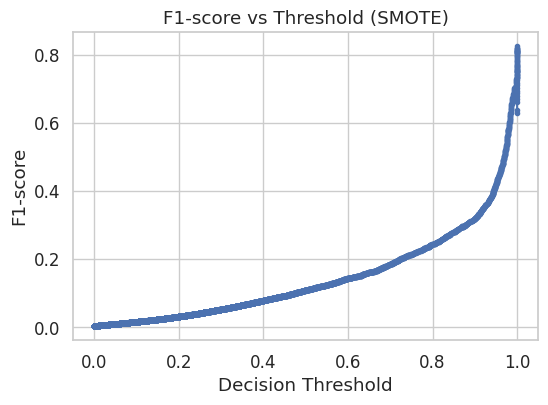

SMOTE → Best threshold: 1.000, Best F1: 0.8247


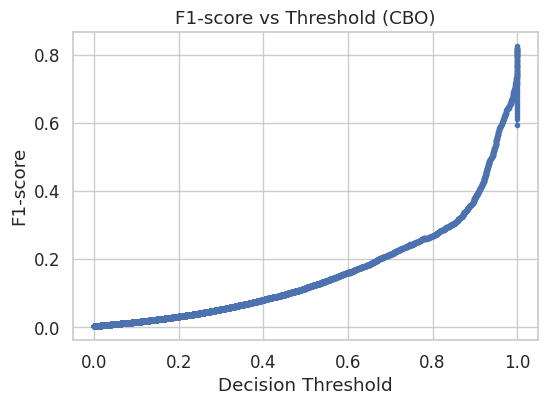

CBO → Best threshold: 1.000, Best F1: 0.8247


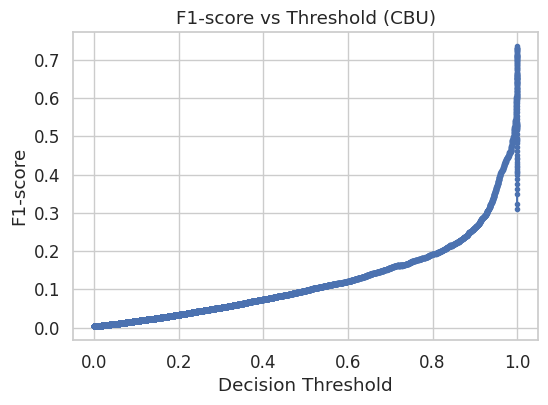

CBU → Best threshold: 1.000, Best F1: 0.7354


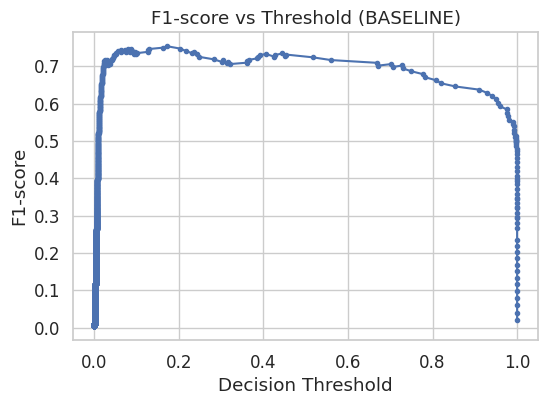

BASELINE → Best threshold: 0.172, Best F1: 0.7538


(np.float64(0.17228603478639753), np.float64(0.7537688437212192))

In [40]:
# SMOTE
plot_f1_vs_threshold(y_test, y_prob_sm, "SMOTE")

# CBO
plot_f1_vs_threshold(y_test, y_prob_cbo, "CBO")

# CBU
plot_f1_vs_threshold(y_test, y_prob_cbu, "CBU")

# BASELINE
plot_f1_vs_threshold(y_test, y_prob, "BASELINE")


## Extra Observation: Why Threshold vs F1 Curve Differs Between Baseline and Resampling Models

During evaluation, we noticed that the **F1 vs Threshold curves** look very different for the baseline model compared to the resampling models (SMOTE, CBO, CBU). This explains why F1-scores were very low at the default threshold (0.5) for the resampled models.

### 1. Baseline Model (Imbalanced Data)
- The model is trained on heavily imbalanced data (~99.8% non-fraud, 0.2% fraud).  
- Logistic Regression becomes conservative and assigns **low fraud probabilities** to most transactions.  
- At threshold = 0.5, only very confident frauds are predicted → **precision is high, recall is moderate**.  
- The F1 curve peaks at a lower threshold (~0.17), because many fraud cases have probabilities below 0.5.

### 2. Resampling Models (SMOTE, CBO, CBU)
- The training data was **balanced** (~50% fraud, 50% non-fraud).  
- Logistic Regression assumes fraud is much more common, so it assigns **higher fraud probabilities** to many transactions.  
- At threshold = 0.5, the model predicts "fraud" for too many non-frauds →  
  - **Recall is very high** (almost all frauds are caught).  
  - **Precision is very low** (lots of false alarms).  
  - As a result, F1 is very poor at 0.5.

### 3. Why the Curves Look Different
- **Baseline**: Probabilities are skewed toward *non-fraud*, so the F1 curve rises early and peaks at a low threshold.  
- **Resampling models**: Probabilities are skewed toward *fraud*, so the F1 curve improves only when threshold is set very high (close to 1.0).  
- This shows that the **distribution of predicted probabilities** is fundamentally different between imbalanced and resampled training.

### Key Insight
- **Threshold tuning is critical** after resampling.  
- Resampling shifts probability distributions, so the default 0.5 threshold is no longer appropriate.  
- By raising the threshold (e.g., ~0.8–1.0), we filter out false alarms and restore a better balance between precision and recall, which significantly improves the F1-score.
